In [20]:
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import matplotlib as mpl
import rdkit, rdkit.Chem, rdkit.Chem.Draw
from rdkit.Chem.Draw import IPythonConsole
import numpy as np
import mordred, mordred.descriptors
from mordred import HydrogenBond, Polarizability
from mordred import SLogP, AcidBase, BertzCT, Aromatic, BondCount
from mordred import Calculator
import exmol as exmol
from rdkit.Chem.Draw import rdDepictor
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, plot_roc_curve
os.environ["CUDA_VISIBLE_DEVICES"]="0"
rdDepictor.SetPreferCoordGen(True)

IPythonConsole.ipython_useSVG = True
# sns.set_context('notebook')
# sns.set_style('dark',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#666666', 'ytick.color': '#666666',
#                         'axes.edgecolor': '#666666', 'axes.linewidth':     0.8 , 'figure.dpi': 300})
color_cycle = [ '#F06060', '#1BBC9B','#F3B562', '#6e5687', '#5C4B51']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 
np.random.seed(0)
soldata = pd.read_csv('https://github.com/whitead/dmol-book/raw/master/data/curated-solubility-dataset.csv')
features_start_at = list(soldata.columns).index('MolWt')

In [21]:
# make object that can compute descriptors
calc = Calculator()
calc.register([HydrogenBond.HBondDonor, HydrogenBond.HBondAcceptor])
calc.register([AcidBase.AcidicGroupCount, AcidBase.BasicGroupCount,
            Aromatic.AromaticBondsCount])
calc.register([SLogP.SLogP, Polarizability.APol,  BertzCT.BertzCT])
calc.register([BondCount.BondCount(type='double'),
            BondCount.BondCount(type='aromatic')])

# make subsample from pandas df
molecules = [rdkit.Chem.MolFromSmiles(smi) for smi in soldata.SMILES]

raw_features = []
for e, c in zip(molecules, calc.map(molecules, quiet=True)):
    raw_features.append([v for v in c.values()])
feature_names = np.array([d.description() for d in calc.descriptors])
    
raw_features

[[0,
  0,
  1,
  1,
  0,
  3.9581000000000017,
  69.89247799999995,
  210.377334085253,
  0,
  0],
 [1,
  1,
  0,
  0,
  11,
  2.405500000000001,
  24.939550999999994,
  511.2292477154967,
  1,
  11],
 [0, 1, 0, 0, 6, 2.1525, 18.005964999999993, 202.66106510209755, 1, 6],
 [2,
  6,
  2,
  0,
  36,
  8.11610000000001,
  115.38730600000001,
  1964.648665828827,
  2,
  36],
 [0,
  6,
  0,
  0,
  12,
  2.4854000000000003,
  67.16178999999998,
  769.8999341256456,
  0,
  12],
 [0,
  0,
  0,
  0,
  6,
  2.638020000000001,
  21.697929999999985,
  211.03322454351994,
  1,
  6],
 [1, 1, 1, 0, 0, 2.6775, 30.306273999999974, 153.9175691117035, 1, 0],
 [4,
  6,
  0,
  0,
  0,
  0.5283999999999995,
  58.55220399999997,
  755.7707920367225,
  4,
  0],
 [0,
  1,
  0,
  0,
  12,
  3.195800000000001,
  28.960343999999985,
  452.9607327512057,
  1,
  12],
 [0,
  5,
  0,
  0,
  12,
  3.497200000000002,
  52.07944599999998,
  582.1507932669278,
  2,
  12],
 [0, 2, 0, 0, 6, 1.5651, 24.26672299999998, 238.2

In [22]:
raw_features = np.array(raw_features)

In [23]:
# feature_names = soldata.columns[features_start_at:]
# raw_features = soldata[feature_names]
labels = soldata['Solubility']

In [24]:
def pick_features(raw_features):
    fm = raw_features.mean()
    fs = raw_features.std()
    def feature_convert(f):
        f -= fm
        f /= fs
        return f

    features = feature_convert(raw_features)

    # we have some nans in features, likely because std was 0
    features = features.astype(float)
    features_select = np.random.randint(0, len(raw_features[0]), size=3) # np.all(np.isfinite(features), axis=0)
    features = features[:, features_select]
    names = feature_names[features_select]
    return features, names

In [25]:
features, names = pick_features(raw_features)
print(features.shape)

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.1, shuffle=True)

clf = RandomForestRegressor(max_depth=10, random_state=0)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)

(9982, 3)


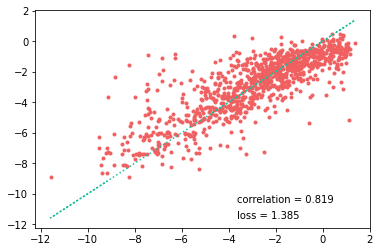

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.1, shuffle=True)

clf = RandomForestRegressor(max_depth=10, random_state=0)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
plt.plot(y_test, predicted, '.')
plt.plot(y_test, y_test, linestyle=':')
plt.text(max(y_test) - 5, min(y_test) + 1, f'correlation = {np.corrcoef(y_test, predicted)[0,1]:.3f}')
plt.text(max(y_test) - 5, min(y_test), f'loss = {np.sqrt(np.mean((y_test - predicted)**2)):.3f}')
plt.savefig('RF-ROC.png')

In [27]:
def model_eval(smiles, _=None):
    molecules = [rdkit.Chem.MolFromSmiles(smi) for smi in smiles]
    # input wrangling. Get some weird values from weird smiles
    # calc = mordred.Calculator(mordred.descriptors, ignore_3D=True)
    # raw_features = calc.pandas(molecules, nproc=8, quiet=True)
#     features = feature_convert(raw_features)
#     features = features.astype(float)
#     features = features[:, features_select]
    labels = clf.predict(np.nan_to_num(features))
    return labels
labels = model_eval(soldata.SMILES, features) #.values[:100])

In [28]:
smi = soldata.SMILES[1000]
space = exmol.sample_space(smi, model_eval, num_samples=2000)

🤘Done🤘: 100%|██████████| 1571.0/1571 [00:02<00:00, 575.09it/s]              


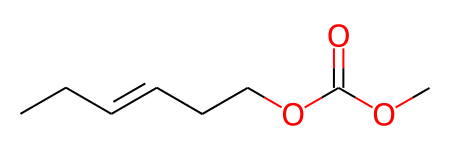

In [29]:
mol = rdkit.Chem.MolFromSmiles(smi)
mol

In [30]:
space_tstats, beta = exmol.lime_explain(space, descriptor_type='MACCS')

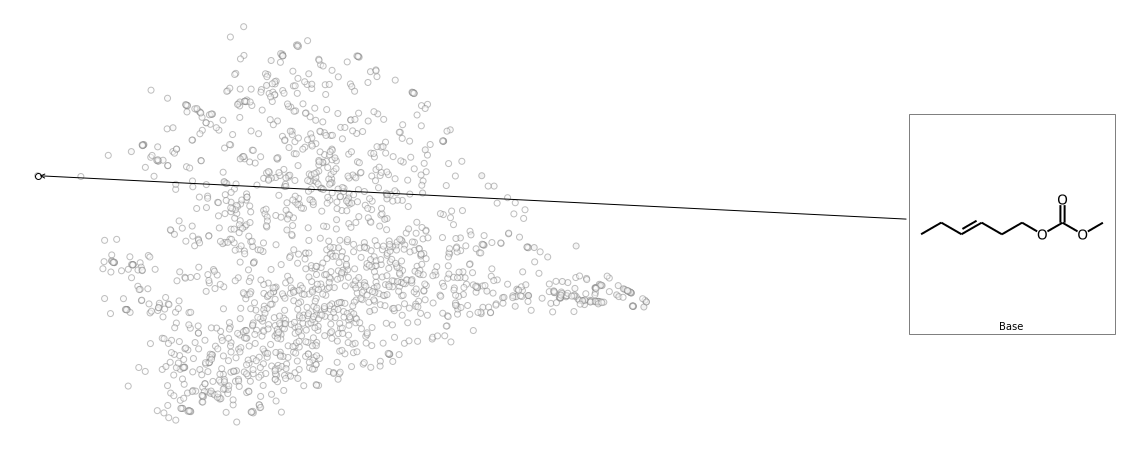

In [31]:
svg = exmol.plot_space(space, [space[0]], mol_size=(200,200), offset=1, plot_by_fit=True, beta = beta) #, cartoon=True)
# plt.colorbar(location='left', label='Solubility [Log M]')

## Compare Feature significance to linear regression

In [32]:
def calc_feature_importance(descriptors, tstats):
    from collections import OrderedDict
    feature_importance = {a:b for a, b in zip(descriptors, tstats)}
    feature_importance = dict(sorted(feature_importance.items(),
                 key=lambda item: abs(item[1]),
                 reverse=True))
    #Fitted space important features
    return feature_importance

def linear_model_tstats(x_mat, y, w=None):
    from sklearn.linear_model import LinearRegression
    noisey_x_mat = (x_mat +
                    np.random.uniform(-1e-4, 1e-4,
                                      size=x_mat.shape)) #* w[:, np.newaxis]
    model = LinearRegression(fit_intercept=False).fit(noisey_x_mat, y)
    xtinv = np.linalg.inv(noisey_x_mat.T @ noisey_x_mat)
    beta = model.coef_
    yhat = model.predict(x_mat)
    resids = yhat - y
    SSR = np.sum(resids**2)
    se2_epsilon = SSR / (len(examples) - len(beta))
    se2_beta = se2_epsilon * xtinv
    # now compute t-statistic for existence of coefficients
    tstat = beta * np.sqrt(1 / np.diag(se2_beta))
    lr_importance = calc_feature_importance(descriptors, tstat.flatten())
    return lr_importance



In [33]:
# Linear regression on features
descriptor_type='Classic'
examples = exmol.get_descriptors(space, descriptor_type)
descriptors = list(examples[0].descriptors.descriptor_names)

x_mat = np.array([list(e.descriptors.descriptors)
                  for e in examples]).reshape(len(examples), -1)
# remove zero variance columns
y = np.array([e.yhat for e in examples]).reshape(len(examples), -1).astype(float)

In [34]:
lr_attr = linear_model_tstats(x_mat, y)

In [45]:
wls_tstats, wls_beta = exmol.lime_explain(space, descriptor_type=descriptor_type)
wls_attr = calc_feature_importance(list(space[0].descriptors.descriptor_names), wls_tstats)
wls_attr

{'Wildman-Crippen LogP': -1.7538520300834533,
 'atomic polarizability': 1.6479110954022633,
 'number of double bonds in non-kekulized structure': 1.644973919502329,
 'Bertz CT': -1.2461686044856273,
 'number of hydrogen bond acceptor': -1.2230535658531303,
 'basic group count': -1.2112967769383995,
 'acidic group count': 0.5784138817087298,
 'number of hydrogen bond donor': -0.24731570927317914,
 'aromatic bonds count': -0.14447869185799486,
 'number of aromatic bonds in non-kekulized structure': 0.14302601347618735}

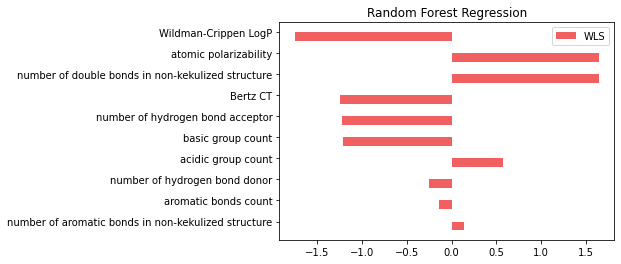

In [70]:
x = (wls_attr.keys())
xaxis = np.arange(len(x))

rf_imp = {a:b for a, b in zip(names, clf.feature_importances_)}
rf_x = np.zeros(len(x))
rf_y = np.zeros(len(x))
for i, j in enumerate(x):
    if j in rf_imp:
        rf_x[i] = i
        rf_y[i] = rf_imp[j]
        
# plt.barh(xaxis-0.2, [lr_attr[i] for i in x], 0.4, label='LR')
plt.barh(xaxis+0.2, [wls_attr[i] for i in x], 0.4, label='WLS')
# plt.barh(rf_x-0.4, rf_y, 0.4, label='RF model')

plt.yticks(xaxis, x)
plt.gca().invert_yaxis()
plt.legend()
plt.title('Random Forest Regression')
plt.savefig('recover_feats.svg', bbox_inches='tight', dpi=180)

[-1.7538520300834533, 1.6479110954022633, 1.644973919502329, -1.2461686044856273, -1.2230535658531303]


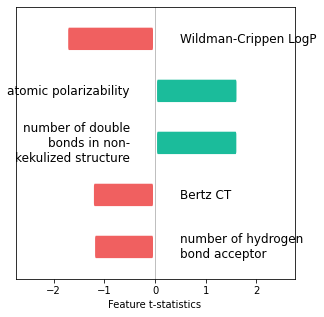

In [68]:
plot_desc(wls_attr, output_file='RF.svg')

In [67]:
from matplotlib.patches import Rectangle, FancyBboxPatch
import textwrap
def plot_desc(feature_importance, output_file, title=None, ax = None):
    if ax is None:
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111)
    t = list(feature_importance.values())
    colors = []
    for ti in t:
        if ti < 0:
            colors.append(color_cycle[0])
        if ti > 0:
            colors.append(color_cycle[1])

    keys = list(feature_importance.keys())

    if len(t) > 0:
        if len(t) > 5:
            t = t[:5]
            keys = keys[:5]
            print(t)
        elif len(t) < 5:
            diff = 5 - len(t)
            for i in range(diff):
                t.append(0)
                keys.append(' ')
        bar1 = ax.barh(range(len(t)), t, color=colors, height=0.75)
        new_patches = []
        for patch in reversed(ax.patches):
            bb = patch.get_bbox()
            color=patch.get_facecolor()
            p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                                abs(bb.width), abs(bb.height),
                                boxstyle="round,pad=-0.040,rounding_size=0.015",
                                ec="none", fc=color,
                                mutation_aspect=4
                                )
            patch.remove()
            new_patches.append(p_bbox)
        for patch in new_patches:
            ax.add_patch(patch)

        count = 1
        for rect, ti, k in zip(bar1, t, keys):
            y = rect.get_y() + rect.get_height()/2.
            if len(k) > 60:
                k = textwrap.fill(k, 20)
            elif len(k) > 25:
                k = textwrap.fill(k, 20)
            if ti < 0:
                x = 0.5
                ax.text(x, y, k, ha='left', va='center', wrap=True, fontsize=12)
                count+=1
            else:
                x = -0.5
                ax.text(x, y, k, ha='right', va='center', wrap=True, fontsize=12)
                count+=1
            
        ax.set_xlim(-np.max(np.absolute(t))-1, np.max(np.absolute(t))+1)
    else:
        patch = ax.get_ylim()
        print(patch)
        ax.text(0.5, 0.5, 'No significant t-stats', ha='right', va='center', wrap=True, fontsize=12)
    
    
    ax.axvline(x=0, color='grey', linewidth=0.5)
    ax.set_yticks([])
    ax.invert_yaxis()
    ax.set_xlabel('Feature t-statistics')
    ax.set_title(title)
    if output_file is not None:
        plt.savefig(output_file, dpi = 300, bbox_inches='tight')

In [135]:
clf.feature_importances_, names

(array([0.37620585, 0.45358756, 0.17020659]),
 array(['Wildman-Crippen LogP', 'Wildman-Crippen LogP', 'Bertz CT'],
       dtype='<U51'))

In [94]:
def get_mi_score(a1, a2):
    from sklearn.metrics import mutual_info_score
    mi = mutual_info_score(a1, a2)
    return mi

lr = []
wls = []
keys = list(lr_attr.keys())
for i in keys:
    lr.append(lr_attr[i])
    wls.append(wls_attr[i])

mi = get_mi_score(lr, wls)

/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


In [84]:
mi

2.302585092994046

In [83]:
## Repeat mutual information analysis

In [69]:
t_stats = []
mi = []
n = 10
labels = soldata['Solubility']
for i in range(n):
    features, names = pick_features(raw_features)
    print(features.shape, names)

    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.1, shuffle=True)
    
    clf = RandomForestRegressor(max_depth=10, random_state=0)
    clf.fit(X_train, y_train)
    predicted = clf.predict(features)
    
    smi = soldata.SMILES[500]
    space = exmol.sample_space(smi, model_eval, num_samples=2000)
    space_tstats, beta = exmol.lime_explain(space, descriptor_type='Classic')
    x_mat = np.array([list(e.descriptors.descriptors)
                  for e in space]).reshape(len(space), -1)
    y = x_mat @ beta
    y_hat = [e.yhat for e in space]
    mi.append(get_mi_score(y_hat, y))
    

(9982, 3) ['acidic group count' 'number of hydrogen bond donor'
 'aromatic bonds count']


🤘Done🤘: 100%|██████████| 3524.0/3524 [00:22<00:00, 155.94it/s]              


NameError: name 'get_mi_score' is not defined

In [136]:
mi

2.302585092994046